**Objective**: To find whether the person is creditworthy or not(target column usually: good/Bad)

In [32]:
import pandas as pd


In [33]:
df=pd.read_csv('/content/german_credit_data.csv')

In [34]:
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [35]:
#find the missing values
df.isnull().sum()

,0
Unnamed: 0,0
Age,0
Sex,0
Job,0
Housing,0
Saving accounts,183
Checking account,394
Credit amount,0
Duration,0
Purpose,0


In [ ]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [38]:

print(df.head())

   Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  Risk  
0         6             radio/TV  good  
1        48             radio/TV   bad  
2        12            education  good  
3        42  furniture/equipment  good  
4        24                  car   bad  


In [7]:
#total number of rows in df
print(len(df))

1000


In [39]:
#what n values are there in savings account
df['Saving accounts'].value_counts()

,count
Saving accounts,
little,603
moderate,103
quite rich,63
rich,48


In [ ]:
df['Checking account'].value_counts()

,count
Checking account,
little,274
moderate,269
rich,63


Problem encountered is there is good amount of missing values in 2 variables named checking account and savings account. so what we can do is

1. Fill the missing values with unknown
2. Fill the missing values with the value of mode
3. Predict using ML models trained on rows that have values this method is called **model-based imputation or supervised imputation**(used when the column have many missing values or column provide significantly for the result)


Intution behind the supervised Imputation is
1. Younger users with low credit amount and unskilled jobs tend to have ‘little’ savings.
2. Older users with long credit duration and skilled jobs may have ‘moderate’ or ‘quite rich’ savings.

In [40]:
# Temporary fill for target variable we're not imputing yet
df['Saving accounts'] = df['Saving accounts'].fillna('unknown')


In [41]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [42]:


# Copy dataframe and label encode object columns
df_temp = df.copy()
cat_cols = ['Sex', 'Housing', 'Saving accounts', 'Purpose', 'Risk']  # include 'Risk'

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_temp[col] = le.fit_transform(df_temp[col].astype(str))
    label_encoders[col] = le

# Encode target column separately (Checking account)
check_le = LabelEncoder()
df_temp['Checking account'] = check_le.fit_transform(df_temp['Checking account'].astype(str))

# Split using encoded df_temp only
df_check_known = df_temp[df['Checking account'].notnull()]
df_check_missing = df_temp[df['Checking account'].isnull()]

# Proceed only if there are missing values
if not df_check_missing.empty:
    # ✅ Drop 'Checking account' and Risk from training features
    X_train = df_check_known.drop(columns=['Checking account'])
    y_train = df_check_known['Checking account']

    rf_check = RandomForestClassifier(random_state=42)
    rf_check.fit(X_train, y_train)

    # Predict missing
    X_missing = df_check_missing.drop(columns=['Checking account'])
    y_pred = rf_check.predict(X_missing)
    y_pred_labels = check_le.inverse_transform(y_pred)

    # Fill predicted values in original df
    df.loc[df['Checking account'].isnull(), 'Checking account'] = y_pred_labels
else:
    print("No missing values in Checking account.")


In [43]:


# Step 1: Fill temporary placeholder for missing Saving accounts
df['Saving accounts'] = df['Saving accounts'].fillna('unknown')

# Step 2: Copy dataframe and label encode necessary categorical features
df_temp2 = df.copy()
cat_cols = ['Sex', 'Housing', 'Purpose', 'Risk', 'Checking account', 'Saving accounts']

label_encoders2 = {}
for col in cat_cols:
    le = LabelEncoder()
    df_temp2[col] = le.fit_transform(df_temp2[col].astype(str))
    label_encoders2[col] = le

# Step 3: Split into known and unknown rows for Saving accounts
saving_encoded_unknown = label_encoders2['Saving accounts'].transform(['unknown'])[0]

df_saving_known = df_temp2[df_temp2['Saving accounts'] != saving_encoded_unknown]
df_saving_missing = df_temp2[df_temp2['Saving accounts'] == saving_encoded_unknown]

# Step 4: Model training and prediction
if not df_saving_missing.empty:
    # Drop 'Saving accounts' only; use 'Risk' and 'Checking account' as features
    X_train = df_saving_known.drop(columns=['Saving accounts'])
    y_train = df_saving_known['Saving accounts']

    rf_saving = RandomForestClassifier(random_state=42)
    rf_saving.fit(X_train, y_train)

    X_missing = df_saving_missing.drop(columns=['Saving accounts'])
    y_pred = rf_saving.predict(X_missing)
    y_pred_labels = label_encoders2['Saving accounts'].inverse_transform(y_pred)

    # Fill back predicted labels
    df.loc[df['Saving accounts'] == 'unknown', 'Saving accounts'] = y_pred_labels
else:
    print("No missing values in Saving accounts.")


In [44]:
df['Saving accounts'].value_counts()

,count
Saving accounts,
little,761
moderate,120
quite rich,68
rich,51


In [45]:
df.head()
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB


,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


Credit amount(Highly skewed)
1. Mean = 3271
2. Std Dev = 2822
3. Min = 250, Max = 18,424 → huge spread!
4. Median (50%) = 2319 < Mean → right-skewed

**Insight**: Consider log transformation(strictly positive values) before modeling. Also, large loan requests might have higher rejection risk.
log transformation do compresses the large values and spreads out the small values, making the distribution more symmetric.
reduces impacts of larger outliers
1. skewness violates many models assumption of normality therefore to mitigate that we use these methods
2. benifits are
     1. Helps Linear Models fit better
     2. Improves model stability
     3.  Reduces bias from extreme outliers


In [46]:
import seaborn as sns

<Axes: xlabel='Risk', ylabel='Credit amount'>

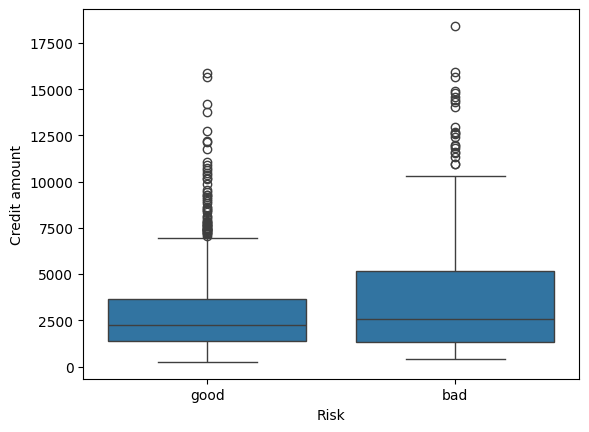

In [47]:
sns.boxplot(x='Risk', y='Credit amount',data=df)

Text(0.5, 1.0, 'credit amount distribution')

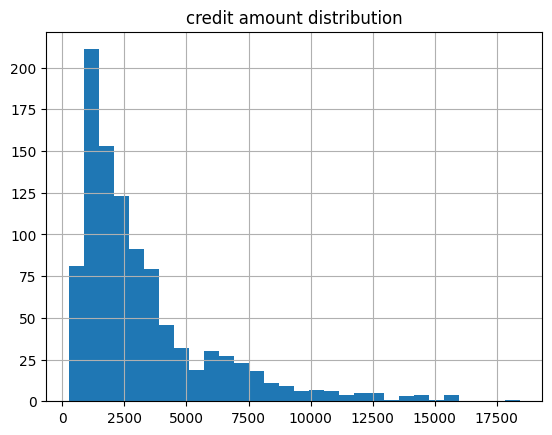

In [48]:
import matplotlib.pyplot as plt
df['Credit amount'].hist(bins=30)
plt.title('credit amount distribution')

<Axes: xlabel='Risk', ylabel='Duration'>

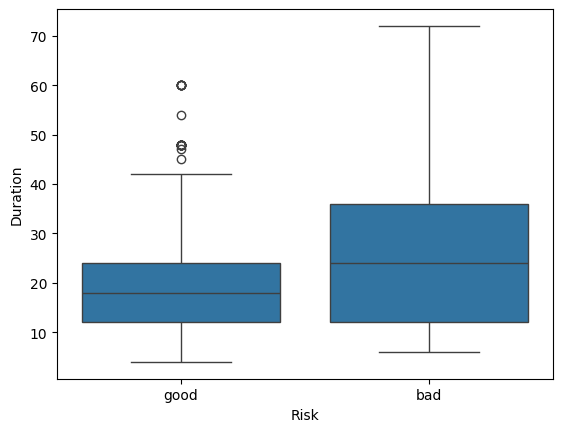

In [49]:
sns.boxplot(x='Risk',y='Duration', data=df)

Text(0.5, 1.0, 'Duration distribution')

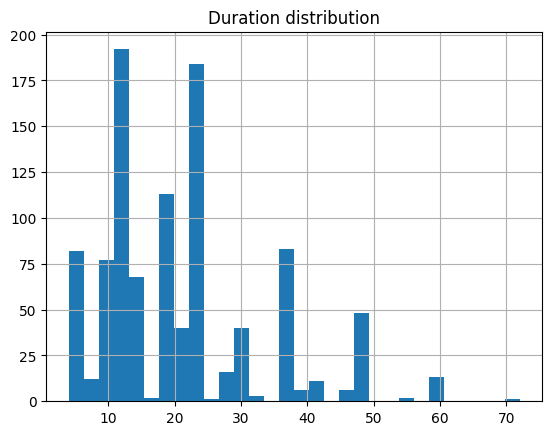

In [50]:
df['Duration'].hist(bins=30)
plt.title('Duration distribution')

In [51]:
import numpy as np

# Overwrite the original 'Credit amount' column with its log-transformed values
df['Credit amount'] = np.log1p(df['Credit amount'])


<Axes: xlabel='Risk', ylabel='Credit amount'>

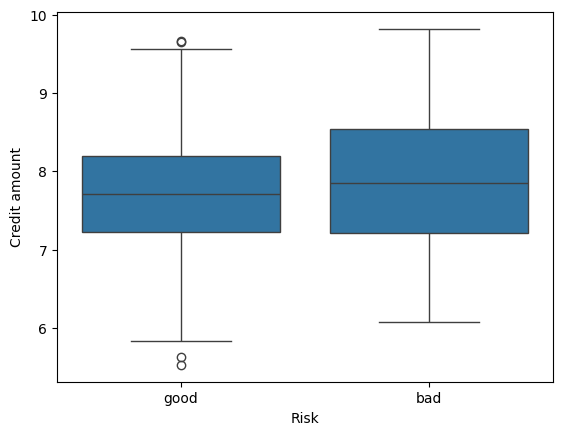

In [52]:
sns.boxplot(x='Risk',y='Credit amount',data=df)

for the Duration there is slight right skew but it not that much, so either we can do the following:

1. leave as-is Tree models will handle it(RF,DT)
2. log transform it so that it can somewhat be normalized
3. clustering(12,24,36) bins so that easy for tree models
4. remove the outliers or standardize the data when features are on different scales, or pca, logistic regression,SVM could be done
5. normalization rescale feature to 0,1 and uses in NN, KNN, Gradient descent

Two methods are
1. Dont Scale Duration and train on XGBoost, Catboost, RF
2. Standardscaler and use LR or SVM

In [53]:
#Method 1

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# --- Encode categorical columns ---
df_model = df.copy()
df_model = df_model.drop(columns=['Unnamed_0'], errors='ignore')

cat_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']

le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    le_dict[col] = le  # save label encoder for inverse_transform later

# --- Feature and target selection ---
X = df_model.drop(columns=['Risk'])      # Features
y = df_model['Risk']                     # Target (0 = bad, 1 = good or vice versa)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ================================
# ✅ 1. RANDOM FOREST MODEL
# ================================
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("📘 Random Forest Results")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print(confusion_matrix(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

# ================================
# ✅ 2. XGBOOST MODEL
# ================================
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

print("\n📘 XGBoost Results")
print("Accuracy:", accuracy_score(y_test, xgb_preds))
print(confusion_matrix(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))


📘 Random Forest Results
Accuracy: 0.73
[[ 14  45]
 [  9 132]]
              precision    recall  f1-score   support

           0       0.61      0.24      0.34        59
           1       0.75      0.94      0.83       141

    accuracy                           0.73       200
   macro avg       0.68      0.59      0.59       200
weighted avg       0.71      0.73      0.69       200


📘 XGBoost Results
Accuracy: 0.68
[[ 16  43]
 [ 21 120]]
              precision    recall  f1-score   support

           0       0.43      0.27      0.33        59
           1       0.74      0.85      0.79       141

    accuracy                           0.68       200
   macro avg       0.58      0.56      0.56       200
weighted avg       0.65      0.68      0.65       200



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:50:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [54]:
pip install lightgbm catboost


In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import lightgbm as lgb
from catboost import CatBoostClassifier

# ------------------------------
# STEP 1: Prepare the data
# ------------------------------

# Copy your cleaned dataframe
df_model = df.copy()
df_model = df_model.drop(columns=['Unnamed_0'], errors='ignore')

# Encode categorical variables
cat_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']
le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    le_dict[col] = le  # for possible inverse transform

# Clean column names for LightGBM
df_model.columns = df_model.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

# Split features and target
X = df_model.drop(columns=['Risk'])
y = df_model['Risk']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------------------
# ✅ LightGBM
# ------------------------------
print("\n💡 LightGBM")
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, lgb_preds))
print(confusion_matrix(y_test, lgb_preds))
print(classification_report(y_test, lgb_preds))

# ------------------------------
# ✅ CatBoost
# ------------------------------
print("\n🐱 CatBoost")
cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, cat_preds))
print(confusion_matrix(y_test, cat_preds))
print(classification_report(y_test, cat_preds))



💡 LightGBM
[LightGBM] [Info] Number of positive: 559, number of negative: 241
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.698750 -> initscore=0.841353
[LightGBM] [Info] Start training from score 0.841353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

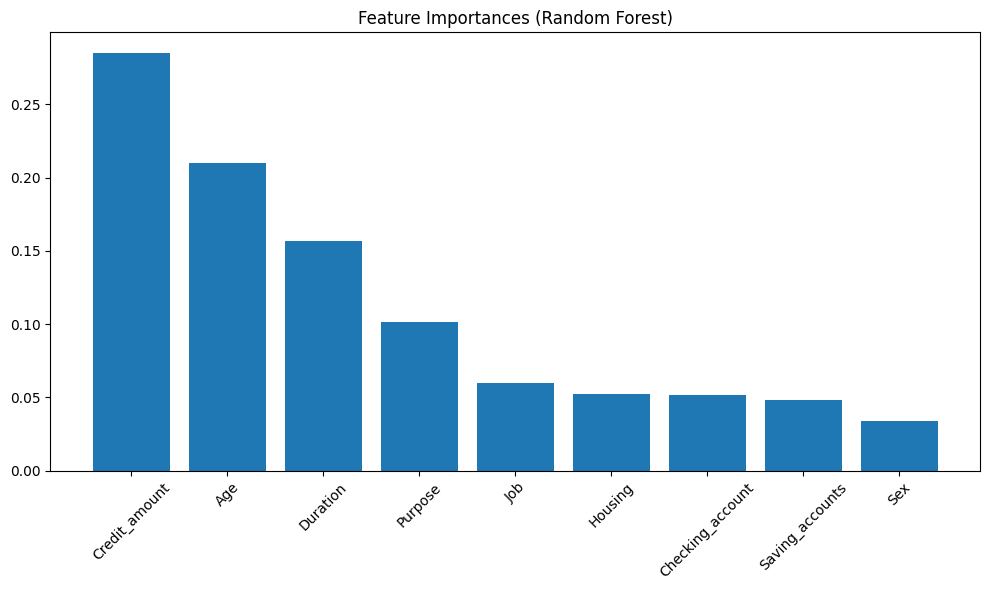

In [56]:
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()


In [57]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print("Cross-validated accuracy:", np.mean(cv_scores))


Cross-validated accuracy: 0.7190000000000001


In [58]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)



Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Retrain using the best parameters
best_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

# Evaluate
print("✅ Accuracy after tuning:", accuracy_score(y_test, y_pred))
print("📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("📋 Classification Report:\n", classification_report(y_test, y_pred))


✅ Accuracy after tuning: 0.715
📊 Confusion Matrix:
 [[ 11  48]
 [  9 132]]
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.19      0.28        59
           1       0.73      0.94      0.82       141

    accuracy                           0.71       200
   macro avg       0.64      0.56      0.55       200
weighted avg       0.68      0.71      0.66       200



In [28]:
pip install shap


 98%|===================| 394/400 [00:11<00:00]       

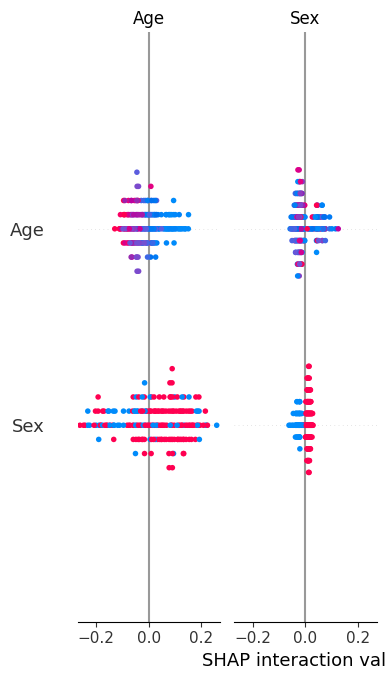

In [64]:
import shap

# Compute SHAP values
explainer = shap.Explainer(best_rf, X_train)
shap_values = explainer(X_test)

# Only show one clean beeswarm plot
shap.summary_plot(shap_values, X_test, plot_size=(10, 6))


now remove unnamed_0 and correct the shap figure and also find accuracies by LR also and intrepret it in business way also. and also learn every code you written.

In [65]:
print(X_test.columns)


Index(['Age', 'Sex', 'Job', 'Housing', 'Saving_accounts', 'Checking_account',
       'Credit_amount', 'Duration', 'Purpose'],
      dtype='object')


In [66]:
shap_values = explainer.shap_values(X_test)

# Use class 1 SHAP values (usually 'bad risk')
shap.summary_plot(shap_values[1], X_test, plot_type='bar')


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [67]:
print(np.array(shap_values).shape)
print(X_test.shape)


(200, 9, 2)
(200, 9)


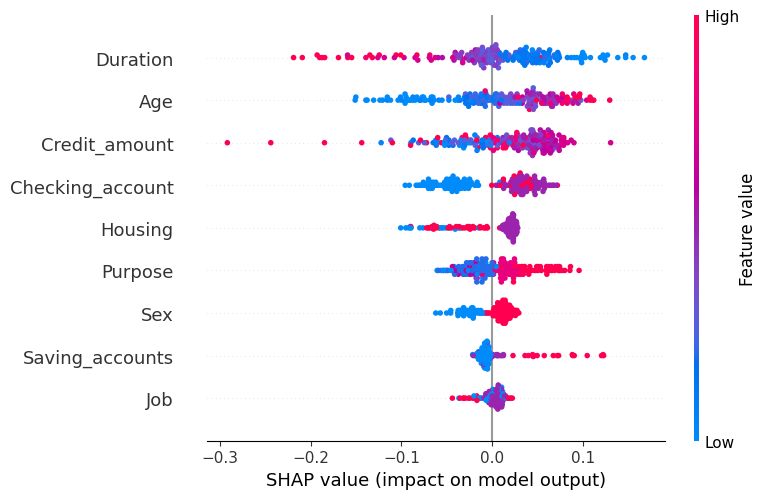

In [68]:
shap.summary_plot(shap_values[:, :, 1], X_test)


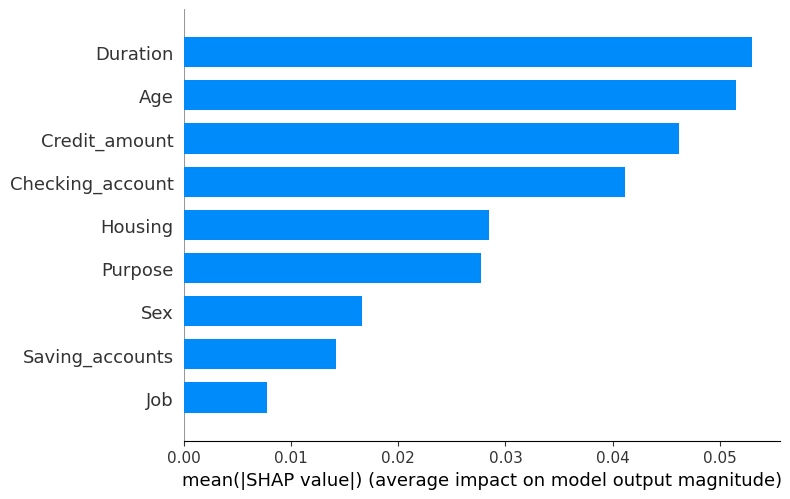

In [69]:
shap.summary_plot(shap_values[:, :, 1], X_test, plot_type='bar')
